In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
import random

# Set random seeds for reproducibility
rand_seed = 12
random.seed(rand_seed)  # Python random seed
np.random.seed(rand_seed)  # NumPy random seed
tf.random.set_seed(rand_seed)  # TensorFlow random seed

In [107]:
# Load your dataset
df = pd.read_csv('VIX_data.csv')  # Ensure this file is in the same directory or provide the full path
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select the features you want to use for prediction
selected_features = [
    'Unemployment Rate',
    'BBB Rate',
    '10-Year Treasury Constant Maturity Rate',
    'Six Month T Bill Rate',
    'SP500 Index'
]


target = 'VIX'  # Assuming 'VIX' is your target variable in the dataset

In [ ]:
# ONLY RAN ONCE TO GET THE FEATURES, TAKES ABOUT 45 MINUTES
# THIS ALGORITHM GIVES ['Unemployment Rate', 'BBB Rate', '10-Year Treasury Constant Maturity Rate', 'Six Month T Bill Rate', 'SP500 Index']
# Algorithm to determine feature combination that gives the best RMSE

df['Next Month VIX'] = df['VIX'].shift(-1)

all_feature_names = ['Unemployment Rate', 'CPI', 'Three Month T Bill Rate',
                     'Six Month T Bill Rate', '10-Year Treasury Constant Maturity Rate',
                     'Fed Rate', 'BBB Rate', 'SP500 Index', 'GDP',
                     'Initial Claims', 'JPY/USD Spot Rate',
                     'Total Nonfarm Employees', 'Spot Crude Oil Price']

best_features = []
best_rmse = float('inf')
remaining_features = all_feature_names.copy()

# Function to create sequences for LSTM
def create_sequences(df, features, time_steps):
    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[features].values[i-time_steps:i])
        y.append(df['Next Month VIX'].values[i])
    return np.array(X), np.array(y)

while remaining_features:
    for feature in remaining_features:
        current_features = best_features + [feature]

        # Create sequences for the current feature set
        X_seq, y_seq = create_sequences(df, current_features, time_steps=20)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.1, shuffle=False)

        # Build and train LSTM model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

        # Predictions and RMSE calculation
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred.flatten()))

        # Update best features if RMSE is improved
        if rmse < best_rmse:
            best_rmse = rmse
            best_features = current_features

    # Remove the tested feature from remaining_features
    remaining_features.remove(feature)

print("Best Features:", set(best_features))

In [108]:
# Define the train and test dates
train_end_date = '2023-10-01'
test_start_date = '2022-10-01'
test_end_date = '2024-09-01'

# Create masks for training and testing
train_mask = (df.index < train_end_date) & (df.index >= '2014-10-1')
test_mask = (df.index >= test_start_date) & (df.index <= test_end_date)

# Split the data based on the masks
X_train = df.loc[train_mask, selected_features]
y_train = df.loc[train_mask, [target]]
X_test = df.loc[test_mask, selected_features]
y_test = df.loc[test_mask, [target]]

In [109]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_X_Full = MinMaxScaler()
scaler_y_Full = MinMaxScaler()

# Fit the scaler on the training data only and transform it
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

# Transform the test data using the scaler fitted on the training data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

X_full_scaled = scaler_X_Full.fit_transform(df[selected_features])
y_full_scaled = scaler_y_Full.fit_transform(df[[target]])

# Define the function to create sequences
def create_sequences(X, y, time_steps=12):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences for the training and testing datasets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)
X_full_seq, y_full_seq = create_sequences(X_full_scaled, y_full_scaled)

In [110]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [111]:
epochs = 100
history = model.fit(
    X_train_seq,
    y_train_seq,
    epochs=epochs,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq)
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 749ms/step - loss: 0.0617 - val_loss: 0.0301
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0386 - val_loss: 0.0022
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0231 - val_loss: 0.0155
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0171 - val_loss: 0.0654
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0190 - val_loss: 0.0919
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0203 - val_loss: 0.0778
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0186 - val_loss: 0.0546
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0168 - val_loss: 0.0357
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0160 - val_loss: 0.0244
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0159 - val_loss: 0.0192
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0160 - val_loss: 0.0180
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0160 - val_l

In [112]:
# Make predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse scaling to get actual VIX values
y_test_actual = scaler_y.inverse_transform(y_test_seq)  # Use the same scaler for the target

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


In [113]:
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Date': df.index[test_mask][12:],  # Adjust the index to match the predictions
    'Actual VIX': y_test_actual.flatten(),
    'Predicted VIX': y_pred.flatten()

})

print(results_df)

# Calculate RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(results_df['Actual VIX'], results_df['Predicted VIX']))
r2 = r2_score(results_df['Actual VIX'], results_df['Predicted VIX'])

print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

         Date  Actual VIX  Predicted VIX
0  2023-10-01      18.775      14.035983
1  2023-11-01      14.165      14.091624
2  2023-12-01      12.595      14.011015
3  2024-01-01      13.280      13.887184
4  2024-02-01      13.850      13.793465
5  2024-03-01      13.785      13.812852
6  2024-04-01      15.745      13.861242
7  2024-05-01      12.920      13.812094
8  2024-06-01      12.645      13.795716
9  2024-07-01      13.190      13.996450
10 2024-08-01      16.690      14.317431
11 2024-09-01      17.070      14.959187
RMSE: 1.8539351770295316
R^2: 0.08347789520106585


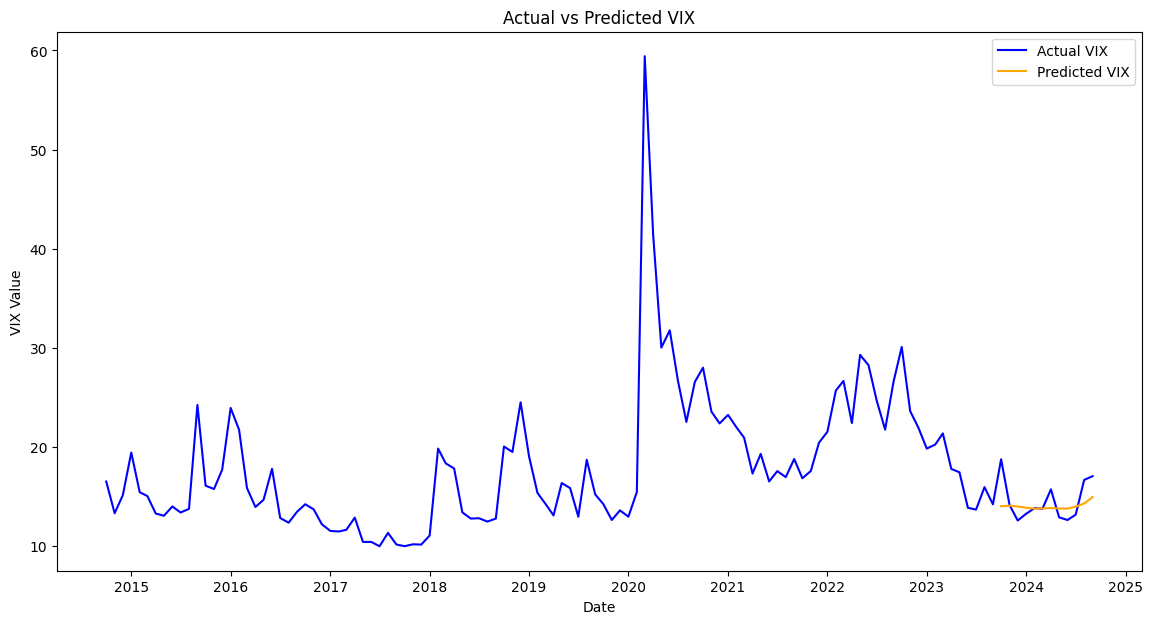

In [114]:
# Plotting the results
results_graph = pd.DataFrame({
    'Date' : df.index,
    'Actual VIX' : df['VIX'].values
})

results_graph['Predicted VIX'] = np.nan  # Initialize with NaN
results_graph.loc[results_graph['Date'].isin(df.index[test_mask][12:]), 'Predicted VIX'] = y_pred.flatten()

plt.figure(figsize=(14, 7))
plt.plot(results_graph['Date'], results_graph['Actual VIX'], label='Actual VIX', color='blue')
plt.plot(results_graph['Date'], results_graph['Predicted VIX'], label='Predicted VIX', color='orange')
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.show()

In [115]:
y_full_pred_scaled = model.predict(X_full_seq)
y_full_pred = scaler_y.inverse_transform(y_full_pred_scaled)  # Inverse scaling to get actual VIX values
y_full_actual = scaler_y.inverse_transform(y_full_seq)  # Use the same scaler for the target

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


          Date  Actual VIX  Predicted VIX
0   2015-10-01      16.110      15.064975
1   2015-11-01      15.775      15.253101
2   2015-12-01      17.730      15.358901
3   2016-01-01      23.950      15.530263
4   2016-02-01      21.745      15.780162
..         ...         ...            ...
103 2024-05-01      12.920      13.314054
104 2024-06-01      12.645      13.279134
105 2024-07-01      13.190      13.289256
106 2024-08-01      16.690      13.303817
107 2024-09-01      17.070      13.472585

[108 rows x 3 columns]
RMSE: 4.400452462408744
R^2: 0.6006123635892471


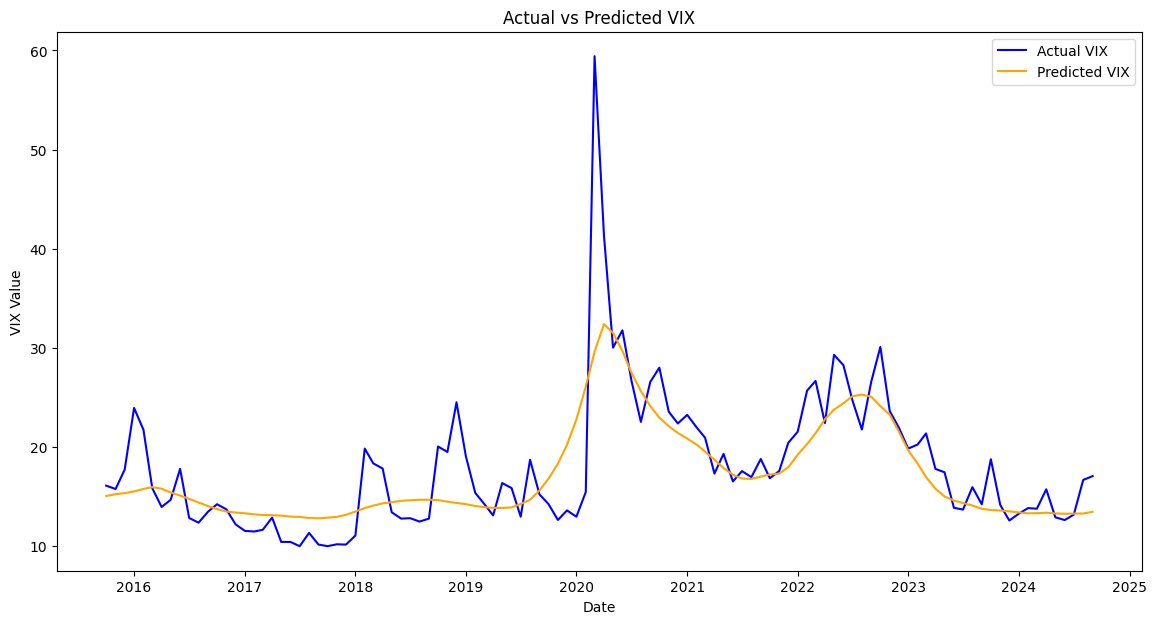

In [116]:
# Create a DataFrame for comparison
results_full_df = pd.DataFrame({
    'Date': df.index[12:],  # Adjust the index to match the predictions
    'Actual VIX': y_full_actual.flatten(),
    'Predicted VIX': y_full_pred.flatten()

})

print(results_full_df)

# Calculate RMSE and R^2 values
rmse_full = np.sqrt(mean_squared_error(results_full_df['Actual VIX'], results_full_df['Predicted VIX']))
r2_full = r2_score(results_full_df['Actual VIX'], results_full_df['Predicted VIX'])

print(f'RMSE: {rmse_full}')
print(f'R^2: {r2_full}')

plt.figure(figsize=(14, 7))
plt.plot(results_full_df['Date'], results_full_df['Actual VIX'], label='Actual VIX', color='blue')
plt.plot(results_full_df['Date'], results_full_df['Predicted VIX'], label='Predicted VIX', color='orange')
plt.title('Actual vs Predicted VIX')
plt.xlabel('Date')
plt.ylabel('VIX Value')
plt.legend()
plt.show()